# Setting

#### Konlpy 사용을 위해 Java와 Jpype 설치 필요

Java : https://www.oracle.com/kr/java/technologies/downloads/#jdk22-windows  
Jpype : https://www.lfd.uci.edu/~gohlke/pythonlibs/#jpype

In [1]:
# !pip install JPype1-1.4.0-cp39-cp39-win_amd64.whl

In [2]:
import pandas as pd
import itertools, re
from collections import Counter
from konlpy.tag import Okt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyvis.network import Network
plt.rcParams['font.family'] = 'Malgun Gothic'  # 폰트 설정

# 데이터 불러오기

In [3]:
df_raw = pd.read_csv('data/단양구경시장 유리네 수제 궁채장아찌 절임 1KG [원산지상세설명에 표시]_500.csv')
df_raw.head(2)
# print(df_raw.head(2))

,Unnamed: 0,reviews,ratings,days,options,buyer_categorys,유통기한,포장,맛 만족도
0,0,항상 맛있게 먹고 있습니다.,5,2024.03.26.,유통기한꽤 남았어요포장꼼꼼해요맛 만족도맛있어요,NaN,꽤 남았어요,꼼꼼해요,맛있어요
1,1,너무 맛나요 ~ 짜지도 않고 적당해요~~ 다음에 또 구매할게용~,5,2024.03.25.,구매자거주인원 2인싱글유통기한꽤 남았어요포장꼼꼼해요맛 만족도맛있어요,구매자거주인원 2인싱글,꽤 남았어요,꼼꼼해요,맛있어요


In [4]:
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       500 non-null    int64 
 1   reviews          499 non-null    object
 2   ratings          500 non-null    int64 
 3   days             500 non-null    object
 4   options          500 non-null    object
 5   buyer_categorys  133 non-null    object
 6   유통기한             500 non-null    object
 7   포장               500 non-null    object
 8   맛 만족도            500 non-null    object
dtypes: int64(2), object(7)
memory usage: 35.3+ KB
None


In [5]:
df = df_raw.iloc[:, 1:]  # Unnamed: 0 열 제거
df = df.dropna(subset = ['reviews'], axis = 0)  # 상품평 결측행 제거
#  이모티콘인 하트만 있는 리뷰가 수집 과정에서 결측으로 처리되었음을 확인함

In [6]:
# 처리가 잘 되었는지 확인
print(df.columns)
print(df.info())

Index(['reviews', 'ratings', 'days', 'options', 'buyer_categorys', '유통기한',
       '포장', '맛 만족도'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, 0 to 499
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   reviews          499 non-null    object
 1   ratings          499 non-null    int64 
 2   days             499 non-null    object
 3   options          499 non-null    object
 4   buyer_categorys  133 non-null    object
 5   유통기한             499 non-null    object
 6   포장               499 non-null    object
 7   맛 만족도            499 non-null    object
dtypes: int64(1), object(7)
memory usage: 35.1+ KB
None


#### 리뷰 본문 결측 1개는 제거 처리, 구매자 정보 결측 366개는 제거하지 않고 활용하여 진행함  

# EDA

별점 평균 :  4.809619238476954


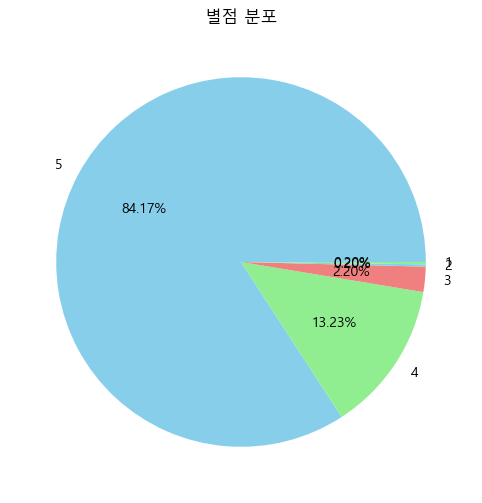

In [7]:
# ratings
print('별점 평균 : ', df['ratings'].mean())

plt.figure(figsize=(8, 6))
df['ratings'].value_counts().plot(kind='pie', autopct='%.2f%%', colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('별점 분포')
plt.ylabel('')
plt.show()

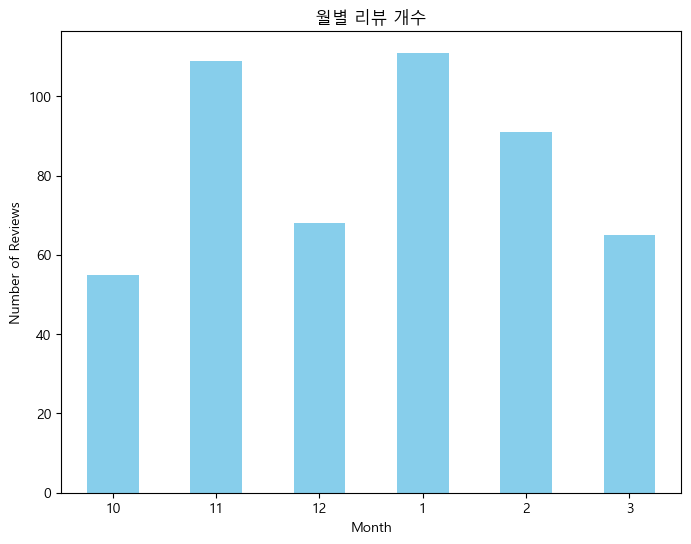

In [8]:
# days
df['days'] = pd.to_datetime(df['days'])
monthly_counts = df.groupby(df['days'].dt.month)['reviews'].count()   # 월별로 묶기
monthly_counts_sorted = monthly_counts.reindex(index=[10, 11, 12, 1, 2, 3])  # 월별 순서 정렬, 23.10 ~ 24.03

plt.figure(figsize=(8, 6))
monthly_counts_sorted.plot(kind='bar', color='skyblue')

plt.title('월별 리뷰 개수')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

리뷰 개수로 판매량을 유추할 수는 있으나, 시간차가 있음을 감안하여야 함  

23년 10월, 23년 12월, 24년 3월의 리뷰 개수가 적음  
수집한 리뷰의 기간이 2023.10.12 ~ 2024.03.26 임을 감안했을 때, 10월과 3월의 리뷰 개수는 타 월과 비슷할 것으로 생각됨  

차후 추가 분석시, 리뷰 수집 개수를 늘리고, 한달사용기의 경우 날짜를 변경시켜 구매일과 유사하게 조정하여 분석할 수 있음

In [9]:
print(df['buyer_categorys'].value_counts())

buyer_categorys
구매자거주인원 4인취학자녀 가정    21
구매자거주인원 3인취학자녀 가정    18
구매자거주인원 4인대가족        16
구매자거주인원 2인신혼/부부      13
구매자거주인원 2인싱글          8
구매자거주인원 4인            8
구매자거주인원 3인            7
구매자거주인원 1인싱글          7
구매자거주인원 1인            6
구매자거주인원 3인대가족         5
구매자거주인원 2인취학자녀 가정     4
구매자거주인원 2인            4
구매자거주인원 5인대가족         4
구매자거주인원 4인영유아 가정      3
구매자거주인원 3인영유아 가정      2
구매자거주인원 4인신혼/부부       2
구매자거주인원 2인대가족         2
구매자거주인원 3인신혼/부부       1
구매자거주인원 5인취학자녀 가정     1
구매자거주인원 6인 이상대가족      1
Name: count, dtype: int64


In [10]:
# 가족구성의 종류보다 거주인원이 가시적으로 결과가 나올 것으로 생각됨

# 숫자 추출 함수
def extract_numbers(text):
    if not pd.isna(text):
        number = re.search(r'\d+', text).group()
        return number

# 거주인원 컬럼 생성
df['거주인원'] = df['buyer_categorys'].apply(extract_numbers)
df.head(2)

,reviews,ratings,days,options,buyer_categorys,유통기한,포장,맛 만족도,거주인원
0,항상 맛있게 먹고 있습니다.,5,2024-03-26,유통기한꽤 남았어요포장꼼꼼해요맛 만족도맛있어요,NaN,꽤 남았어요,꼼꼼해요,맛있어요,None
1,너무 맛나요 ~ 짜지도 않고 적당해요~~ 다음에 또 구매할게용~,5,2024-03-25,구매자거주인원 2인싱글유통기한꽤 남았어요포장꼼꼼해요맛 만족도맛있어요,구매자거주인원 2인싱글,꽤 남았어요,꼼꼼해요,맛있어요,2


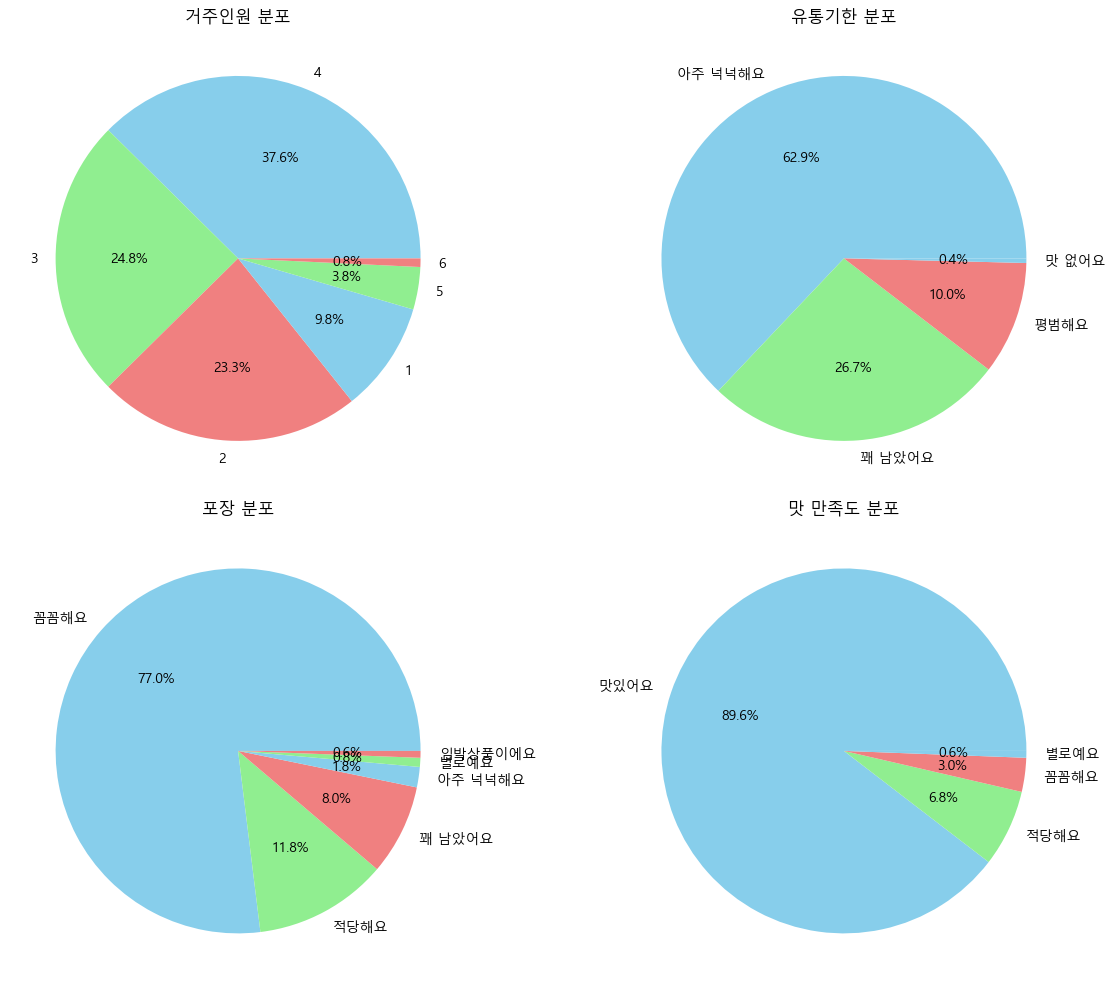

In [11]:
# 유통기한, 포장, 맛 만족도
columns_to_plot = ['거주인원', '유통기한', '포장', '맛 만족도']

# 각각의 서브플롯에 파이 차트 그리기
fig = plt.figure(figsize=(12, 10))

for i, col in enumerate(columns_to_plot, start=1):
    ax = fig.add_subplot(2, 2, i)
    df[col].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'], ax=ax)
    ax.set_title(f'{col} 분포')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

궁채장아찌는 반찬류로 1인 가족보다는 다인가족이 자주 구매하는 것으로 보임  
5,6 인 가족 구성 비율이 적은 것은 실제로 5,6인 가족 구성이 적기 때문임으로 유추됨  

유통기한, 포장, 맛은 전체적으로 좋은 평가를 이루는 편임. 긍정적인 평가의 비율은 맛, 포장, 유통기한 순으로 높음. 제품을 보완한다면 유통기한, 포장, 맛 순으로 보완이 필요하다고 판단할 수 있음.

# 텍스트 분석

### 형태소 분석, 불용어 처리

In [12]:
reviews = df['reviews']

okt = Okt()  # 형태소 분석 객체 생성

# 형태소 분석
n = 6
for i in range(n):
    print('처리 전 : ', reviews[i])
    print('처리 후 : ', okt.pos(reviews[i], stem = True, norm = True))
    print('')

처리 전 :  항상 맛있게 먹고 있습니다.
처리 후 :  [('항상', 'Noun'), ('맛있다', 'Adjective'), ('먹다', 'Verb'), ('있다', 'Adjective'), ('.', 'Punctuation')]

처리 전 :  너무 맛나요 ~ 짜지도 않고 적당해요~~ 다음에 또 구매할게용~
처리 후 :  [('너무', 'Adverb'), ('맛', 'Noun'), ('나', 'Josa'), ('요', 'Noun'), ('~', 'Punctuation'), ('짜지다', 'Verb'), ('않다', 'Verb'), ('적당하다', 'Adjective'), ('~~', 'Punctuation'), ('다음', 'Noun'), ('에', 'Josa'), ('또', 'Noun'), ('구매', 'Noun'), ('하다', 'Verb'), ('~', 'Punctuation')]

처리 전 :  지인추천으로 사먹고 맛있어서 두통재주문했어요. 집에서 고기먹을때 없으면 서운한 반찬이 되었습니다 ㅎㅎㅎ 이거있으면 고깃집 안부러워요 짜지도않고 아삭아삭한 식감이 중동적입니다. 다먹으면 또 시킬게요
처리 후 :  [('지인', 'Noun'), ('추천', 'Noun'), ('으로', 'Josa'), ('사먹다', 'Verb'), ('맛있다', 'Adjective'), ('두통', 'Noun'), ('재', 'Noun'), ('주문', 'Noun'), ('하다', 'Verb'), ('.', 'Punctuation'), ('집', 'Noun'), ('에서', 'Josa'), ('고기', 'Noun'), ('먹다', 'Verb'), ('때', 'Noun'), ('없다', 'Adjective'), ('서운하다', 'Adjective'), ('반찬', 'Noun'), ('이', 'Josa'), ('되어다', 'Verb'), ('ㅎㅎㅎ', 'KoreanParticle'), ('이다', 'Verb'), ('고깃집', 'Noun'), ('안', 'VerbPrefix'), (

### 처리된 리뷰를 살펴본 결과, 아래 단어들이 포함되어야 한다고 판단하여 명사, 형용사, 동사를 추출하는 것으로 함  

| 종류 | 단어 |
| --- | ---- |
| Noun | 반찬, 고기, 식감, 포장 |
| Adjective | 맛있다, 짜지다, 적당하다, 좋아하다 |
| Verb | 시키다, 익다, 좋다, 씹다, 달다 |

### 분석 요구사항 및 분석 결과에 따라 품사의 종류는 변경이 필요할 수 있음  

In [13]:
# 불용어 사전
stopword_dictionary = pd.read_csv('data/Korean_Stopwords.txt', header=None, encoding='utf-8')[0].tolist()

# 추가 불용어 - 분석 중 필요시 추가
additional_stopword = ['하다', '이다', '않다', '삭', '재다', '요', '더', '들다', '콤', '넘다', '식', '되어다', '되다', '생각', '늘', '감다']

stopwords = stopword_dictionary + additional_stopword

In [14]:
# 품사 추출, 불용어 제거 함수
def remove_stopword(reviews, stopwords):
    result = []   # 전체 리뷰를 저장할 리스트
    for reveiw in reviews:
        reveiw_words = okt.pos(reveiw,  # 모든 형태소 품사부착
                            stem=True, norm=True)  # 어간 추출, 정규화

        clena_words = []   # 각 리뷰를 저장할 리스트
        for word in reveiw_words:
            if word[1] in ['Noun', 'Adjective', 'Verb']:  
                if word[0] not in stopwords:   # 불용어 제거
                    clena_words.append(word[0])
        result.append(clena_words)
    return result

clean_reviews = remove_stopword(reviews = reviews, stopwords = stopwords)
print(clean_reviews[:3])

[['항상', '맛있다', '먹다'], ['맛', '짜지다', '적당하다', '구매'], ['지인', '추천', '사먹다', '맛있다', '두통', '재', '주문', '집', '고기', '먹다', '없다', '서운하다', '반찬', '고깃집', '부럽다', '짜지다', '식감', '중동', '먹다']]


# WordCloud

In [15]:
# 모든 리뷰의 단어를 통합
words_list_all = list(itertools.chain.from_iterable(clean_reviews))

# 빈도 카운팅
count = Counter(words_list_all)
print('상위 10개 단어 : ', count.most_common(10))

상위 10개 단어 :  [('맛있다', 314), ('먹다', 282), ('좋다', 168), ('맛', 108), ('주문', 88), ('궁채', 66), ('자다', 62), ('장아찌', 52), ('구매', 48), ('배송', 46)]


In [16]:
# 단어와 빈도 수를 csv로 저장하여 직접 확인
df_count = pd.DataFrame(count.most_common(), columns = ['word', 'freq'])
df_count.to_csv('word_count.csv', index= False) 

빈도 수가 10 이상인 단어 중 불필요하다고 판단되는 '하다', '이다', '않다', '삭', '재다', '요', '더', '들다', '콤', '넘다', '식', '되어다', '되다', '생각', '늘', '감다' 를 추가 불용어로 지정하여 다시 분석함  
모든 불용어를 찾아서 제거하면 좋으나, 시간적 문제가 있으며 분석 결과에서 중요한 것은 큰 빈도수를 가진 단어임  

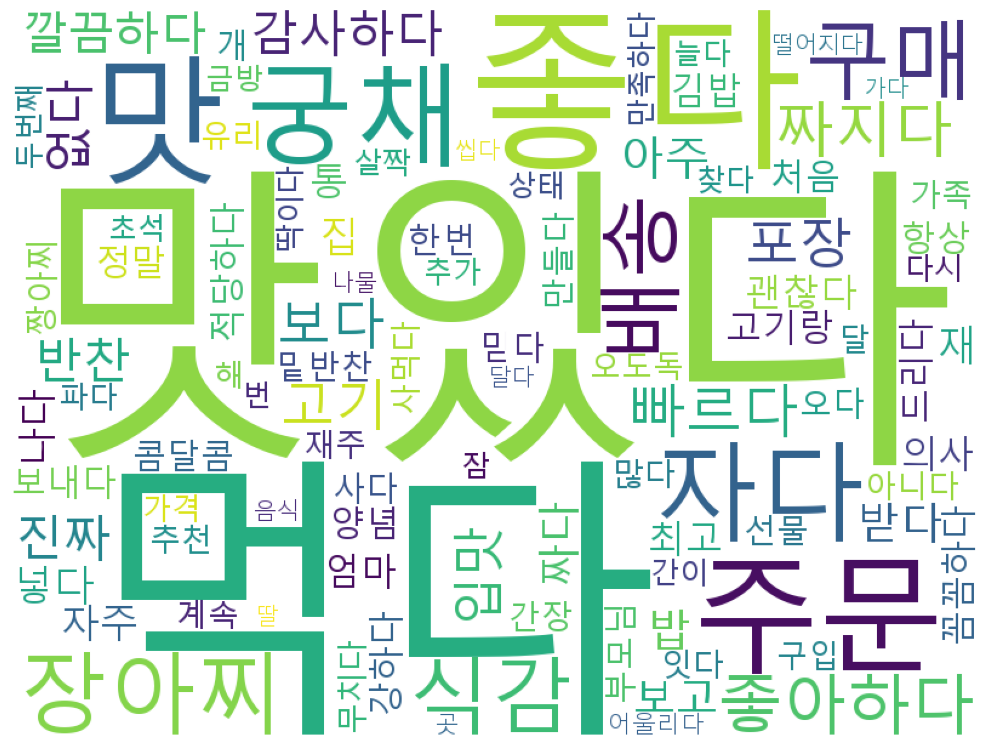

In [17]:
# WordCloud 생성
wordcloud = WordCloud(max_words = 100, 
                      font_path='C:\Windows\Fonts\malgun.ttf', 
                      background_color='white', width=800, height=600)
wordcloud.generate_from_frequencies(count)

# 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis('off')  # 축 제거
plt.tight_layout()  # 여백 최소화
plt.savefig('WordCloud.png', bbox_inches='tight', dpi=500)
plt.show()

# Network Analysis

In [26]:
network_count = {}

# 각 리뷰별로 단어조합을 구성해서 빈도 수를 카운팅
for words in clean_reviews:
    words = list(set(words))  # 줄별 중복 제거
    for idx, a in enumerate(words):
        for b in words[idx + 1:]:  # 한 단어씩 비교
            if a == b:
                continue
            elif a > b:
                network_count[b, a] = network_count.get((b, a), 0) + 1
            else:
                network_count[a, b] = network_count.get((a, b), 0) + 1

print(network_count)

{('맛있다', '항상'): 7, ('맛있다', '먹다'): 128, ('먹다', '항상'): 9, ('구매', '적당하다'): 1, ('적당하다', '짜지다'): 2, ('맛', '적당하다'): 2, ('구매', '짜지다'): 3, ('구매', '맛'): 11, ('맛', '짜지다'): 9, ('맛있다', '서운하다'): 1, ('두통', '맛있다'): 3, ('맛있다', '집'): 10, ('고깃집', '맛있다'): 4, ('맛있다', '추천'): 5, ('맛있다', '지인'): 2, ('맛있다', '주문'): 50, ('맛있다', '사먹다'): 6, ('고기', '맛있다'): 12, ('맛있다', '중동'): 1, ('맛있다', '재'): 7, ('맛있다', '부럽다'): 1, ('맛있다', '없다'): 15, ('맛있다', '반찬'): 11, ('맛있다', '짜지다'): 19, ('맛있다', '식감'): 21, ('두통', '서운하다'): 1, ('서운하다', '집'): 1, ('고깃집', '서운하다'): 1, ('서운하다', '추천'): 1, ('서운하다', '지인'): 1, ('서운하다', '주문'): 1, ('사먹다', '서운하다'): 1, ('고기', '서운하다'): 2, ('서운하다', '중동'): 1, ('서운하다', '재'): 1, ('부럽다', '서운하다'): 1, ('서운하다', '없다'): 2, ('먹다', '서운하다'): 2, ('반찬', '서운하다'): 1, ('서운하다', '짜지다'): 1, ('서운하다', '식감'): 1, ('두통', '집'): 1, ('고깃집', '두통'): 1, ('두통', '추천'): 1, ('두통', '지인'): 1, ('두통', '주문'): 1, ('두통', '사먹다'): 1, ('고기', '두통'): 1, ('두통', '중동'): 1, ('두통', '재'): 1, ('두통', '부럽다'): 1, ('두통', '없다'): 1, ('두통', '먹다'): 2, ('두통', '반찬'): 1, ('두통', '

In [53]:
# DataFrame 형태로 변환
network = pd.DataFrame.from_dict(network_count, orient='index')
network.rename(columns={0: 'freq'}, inplace=True)
network.to_csv('network_count.csv', index= True) 

# 상위 확인
nx_n = 20
nx_top = network.sort_values(by='freq', ascending=False).head(nx_n)
print(f'단어조합 상위 {nx_n}개는 다음과 같습니다. \n {nx_top}')

단어조합 상위 20개는 다음과 같습니다. 
             freq
(맛있다, 먹다)    128
(맛있다, 좋다)     52
(맛있다, 주문)     50
(먹다, 좋다)      47
(먹다, 자다)      45
(맛, 먹다)       39
(궁채, 먹다)      37
(맛, 좋다)       37
(궁채, 맛있다)     36
(먹다, 주문)      34
(식감, 좋다)      32
(맛있다, 자다)     32
(배송, 빠르다)     30
(궁채, 장아찌)     29
(맛있다, 장아찌)    28
(먹다, 식감)      27
(먹다, 장아찌)     27
(맛, 맛있다)      25
(구매, 맛있다)     24
(고기, 먹다)      23


In [76]:
# Network Graph 생성
# 배경 생성
net = Network(height="800px", width="800px", 
              bgcolor="black", font_color="white")

# 노드, 엣지 추가
for index, row in nx_top.iterrows():
    node1, node2 = index  # 튜플 언패킹
    net.add_node(node1, label=node1)
    net.add_node(node2, label=node2)
    net.add_edge(node1, node2, value = int(row['freq']))

# 세부 디자인 조정
net.repulsion(node_distance = 150, 
              central_gravity = 0.7,   # 중심에 모이는 정도
              spring_length = 100, spring_strength = 0.05)   # 엣지 길이, 두께

# 옵션 버튼 보이기
net.show_buttons(filter_= ['nodes', 'edges'])

# 파일 저장
net.save_graph("Network_Graph.html")  # html 파일 확인 필요